# Projeto 6 - Classificação de Imagens - PyTorch e Transfer Learning

## Motivação
Utilização de redes pré treinadas, o que possibilita a aplicação utilizando um conjunto reduzido de observações para treinamento dos modelos, já que treinar uma rede do zero demandaria dezenas de milhares de imagens, o que pode inviabilizar a aplicação.



## Objeto de Estudo

Precisamos de um mínimo produto viável que possa ser testado para classificar produtos das lojas. Existe uma dificuldade de novos vendedores de diferenciar algumas frutas e vegetais, entao a ideia é fazer uma aplicaçãoi que ajude nessa classificação. 

## Criação e separação de bases



Com as imagens baixadas do google images, podemos separá-las em treino, validação e teste. Isso requer uma pasta "raw" dentro de "data", com uma pasta para cada classe a ser treinada.

In [1]:
#!pip install torch
#!pip install torchvision pillow

In [2]:
# Importar as bibliotecas necessárias
from matplotlib import pyplot as plt
import numpy as np
import os
import PIL.Image

import time
import torch, torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim


In [3]:
# Separando as imagens em treino, validação e teste

diretorio_base_imagens = './data/raw'
pastas_com_nomes_de_vegetais = os.listdir('./data/raw')
pastas_com_nomes_de_vegetais

['batata', 'cenoura', 'limao', 'tomate']

In [4]:
#Criando uma separação estratificada

quantidade_por_label = {pasta: len(os.listdir(os.path.join(diretorio_base_imagens, pasta))) for pasta in pastas_com_nomes_de_vegetais}

quantidade_por_label

{'batata': 146, 'cenoura': 181, 'limao': 111, 'tomate': 107}

In [5]:
#Criuando as pastas de treino, validação e testes

diretorio_imagens_processadas = './data/processed/'

dir_treino=os.path.join(diretorio_imagens_processadas, 'treino')
dir_validacao=os.path.join(diretorio_imagens_processadas, 'validacao')
dir_teste=os.path.join(diretorio_imagens_processadas, 'teste')

if not os.path.exists(dir_treino):
    os.makedirs(dir_treino)
    
if not os.path.exists(dir_validacao):
    os.makedirs(dir_validacao)
        
if not os.path.exists(dir_teste):
    os.makedirs(dir_teste)

In [6]:
import shutil
from sklearn.model_selection import train_test_split

#Criando as pastas para cada classe

for classe in pastas_com_nomes_de_vegetais:
    #os.path.join cria path com os separadores corretos para cada sistema operacional
    dir_classe_treino = os.path.join(dir_treino, classe)
    dir_classe_validacao = os.path.join(dir_validacao, classe)
    dir_classe_teste = os.path.join(dir_teste, classe)
    
    #testando se as pastas ja existem:
    if not os.path.exists(dir_classe_treino):
        os.makedirs(dir_classe_treino)
    
    if not os.path.exists(dir_classe_validacao):
        os.makedirs(dir_classe_validacao)
        
    if not os.path.exists(dir_classe_teste):
        os.makedirs(dir_classe_teste)
    
    #caminho completo para a pasta com imagens originais
    pasta_classe = os.path.join(diretorio_base_imagens, classe)
    
    #Listando os arquivos de imagem para a classe
    arquivos_classe = os.listdir(pasta_classe)
    
    #Separando 80% para treino e 20% para validação + teste
    treino, valid_teste = train_test_split(arquivos_classe, shuffle=True, test_size=0.2, random_state=42)
    
    #Separando os 20% de validação + teste em 10% validação e 10% teste
    validacao, teste = train_test_split(valid_teste, shuffle=True, test_size=0.5, random_state=42)
    
    del valid_teste
    
    print(f'{classe} - treino: {len(treino)} - valid: {len(validacao)} - teste: {len(teste)} - total {len(arquivos_classe)}')
          
    #Copiando os arquivos efetivamente para as respectivas pastas
    for imagem_treino in treino:
          caminho_origem = os.path.join(diretorio_base_imagens, classe, imagem_treino)
          caminho_destino = os.path.join(dir_classe_treino, imagem_treino)
          
          shutil.copy(caminho_origem, caminho_destino)
          
    for imagem_validacao in validacao:
          caminho_origem = os.path.join(diretorio_base_imagens, classe, imagem_validacao)
          caminho_destino = os.path.join(dir_classe_validacao, imagem_validacao)
          
          shutil.copy(caminho_origem, caminho_destino)
          
    for imagem_teste in teste:
          caminho_origem = os.path.join(diretorio_base_imagens, classe, imagem_teste)
          caminho_destino = os.path.join(dir_classe_teste, imagem_teste)
          
          shutil.copy(caminho_origem, caminho_destino)
    
    

batata - treino: 116 - valid: 15 - teste: 15 - total 146
cenoura - treino: 144 - valid: 18 - teste: 19 - total 181
limao - treino: 88 - valid: 11 - teste: 12 - total 111
tomate - treino: 85 - valid: 11 - teste: 11 - total 107


## Pré Processamento

Serão criadas transformações para redimensionar as imagens e transforma-las em tensores PyTorch

In [7]:
#Setando o tamanho da imagem
image_size = 100

#Transformando as imagens: Data augmentation! Neste caso estamos apenas fazendo o redimensionamento da imagem
transformacoes_de_imagens = {
    
    'treino': transforms.Compose([transforms.Resize (size = [image_size, image_size]),
                                 transforms.ToTensor(),
                                 ]),
    
    'validacao': transforms.Compose([transforms.Resize (size = [image_size, image_size]),
                                 transforms.ToTensor(),
                                 ]),
    
    'teste': transforms.Compose([transforms.Resize (size = [image_size, image_size]),
                                 transforms.ToTensor(),
                                 ]),
       
}

In [8]:
#Carregar as imagens

pasta_treino = dir_treino
pasta_validacao = dir_validacao
pasta_teste = dir_teste

pasta_treino, pasta_validacao, pasta_teste

('./data/processed/treino',
 './data/processed/validacao',
 './data/processed/teste')

## Preparação para o treinamento

Vamos definir informaçõpes importantes para o treinamento do modelo. Tamanho do batch, número de classes, datasets, data loaders, otimizadores.

In [9]:
#tamanho do batch de treinamento
tamanho_do_batch = 8

#Determinando o numero de classes (verduras/frutas)
numero_de_classes = len(os.listdir(pasta_treino))

numero_de_classes

4

In [10]:
#Carregar imagens usando o datasets do torchvision

data = {
    'treino':datasets.ImageFolder(root = pasta_treino, transform=transformacoes_de_imagens['treino']),
    'validacao': datasets.ImageFolder(root = pasta_validacao, transform=transformacoes_de_imagens['validacao'])
}

In [11]:
data

{'treino': Dataset ImageFolder
     Number of datapoints: 433
     Root location: ./data/processed/treino
     StandardTransform
 Transform: Compose(
                Resize(size=[100, 100], interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ),
 'validacao': Dataset ImageFolder
     Number of datapoints: 55
     Root location: ./data/processed/validacao
     StandardTransform
 Transform: Compose(
                Resize(size=[100, 100], interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            )}

In [12]:
#Mapear indices com os nomes das classes
indice_para_classe = {indice:classe for classe, indice in data['treino'].class_to_idx.items()}

indice_para_classe

{0: 'batata', 1: 'cenoura', 2: 'limao', 3: 'tomate'}

In [13]:
#Quantidade de imagens para serem utilizados para calcular erro médio e acuracia
num_imagens_treino = len(data['treino'])
num_imagens_validacao = len(data['validacao'])

num_imagens_treino, num_imagens_validacao

(433, 55)

In [14]:
#Criando os dataloaders para treino e validação
data_loader_treino = DataLoader(data['treino'], batch_size = tamanho_do_batch, shuffle=True)
data_loader_validacao = DataLoader(data['validacao'], batch_size = tamanho_do_batch, shuffle=True)

In [15]:
data_loader_treino, data_loader_validacao

(<torch.utils.data.dataloader.DataLoader at 0x276770b6b90>,
 <torch.utils.data.dataloader.DataLoader at 0x276770b6da0>)

## Checando algumas imagens

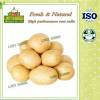

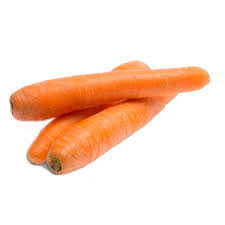

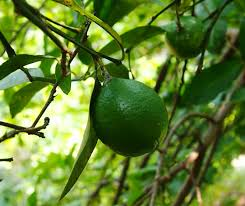

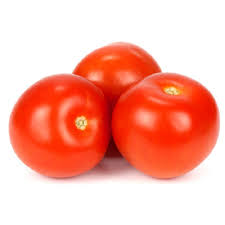

In [16]:
from IPython.display import Image

for classe in indice_para_classe.values():
    pasta_classe = os.path.join(pasta_treino, classe)
    arquivo_imagem = os.listdir(pasta_classe)[1]
    img = Image(filename=os.path.join(pasta_classe, arquivo_imagem))
    display(img)


## Transfer Learning

Será utilizado a Alexnet, famosa por ter ganhado o premio de melhor classificador do banco Imagenet.

In [17]:
#Carregando Alexnet, ja pre-treinado
alexnet=models.alexnet(pretrained=True)

alexnet

C:\Users\horiu\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\horiu\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [18]:
type(alexnet)

torchvision.models.alexnet.AlexNet

In [19]:
#Congelar os parametros da rede pré treinada
#required_grad=False desliga o treinamento e atualização dos pesos (coeficientes) das camadas da rede neural

for param in alexnet.parameters():
    param.requires_grad = False

In [20]:
#Mudar ultima camada para alterar o número de classes
#Aproveitamos a rede inteira, só plugamos uma camada final para a identificação dos nossos hortifrutis

#Alterando de Linear(in_features=4096, out_features=1000, bias=True) para Linear(in_features=4096, out_features=4, bias=True), pois temos 4 classes
alexnet.classifier[6]=nn.Linear(4096, numero_de_classes)

#Incluindo softmax, que faz com que as probabilidades de ser cenoura, batata, limão ou tomate seja 1
alexnet.classifier.add_module("7", nn.LogSoftmax(dim=1))

alexnet


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [21]:
#Ultima camada ja é criada com requires_grad=True
parametros_ultima_camada = alexnet.classifier[6].parameters()
[parametro for parametro in parametros_ultima_camada][0].requires_grad

True

In [22]:
#Utilizando a função de erro de entropia cruzada, bastante comum para problemas de classificação

funcao_erro = nn.CrossEntropyLoss()

## Otimizador

O otimizador é quem efetivamente muda os pesos da rede de acordo com algum algoritmo. Nesse caso, vamos utilizar o Adam Optimizer, mas poderiamos utilizar o Stochastic Gradient Descent, por exemplo

In [23]:
otimizador = optim.Adam(alexnet.parameters())
otimizador

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

## Treinar e validar

O treinamento realiza varios caminhos para frente (forward: previsao), calculos de erro e backward (backpropagation: aprendizado com o erro). A cada época, todas as imagens do treino são utilizadas para otimizar os parâmetros da rede. Dentro de cada época, utilizamos o treinamento em batch ao inves de realizar o treinamento imagem por imagem.

Na validação, lembrar que nao queremos manter o cálculo de gradientes, pois nao vamos realizar o backpropagation.

In [24]:
def treinar_e_validar (modelo, metrica_erro, otimizador, epocas=10):
    '''função para treinamento e validação.
    Parametros: modelo - modelo para treinar e validar; metrica_erro - criterio de erro para minimização; otimizador - para alterar os parametros da rede; epocas - numero de epocas(default = 10)
    Retorna: melhor_modelo: modelo treinado com a melhor acuracia na validação
    historico: (dicionario) historico com erro no treinamento, erro na validação
    
    '''
    
    #inicializando historico, a melhor acuracia de validação e o melhor modelo de acordo com a validação
    historico = []
    melhor_acuracia = 0.0
    melhor_modelo = None
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    print (device)
    
    #Cada época perpassa todas as imagens do treino e calcula erros de treino e validação para aprendizado da rede neural
    for epoca in range(epocas):
        inicio_epoca = time.time()
        print("\n\nÉpoca: {}/{}".format(epoca+1, epocas))
        
        #Erro e acuracia de treino nessa época
        erro_treino=0.0
        acertos_treino=0.0
        
        #Erro e acuracia de validacao nessa epoca
        erro_validacao = 0.0
        acertos_validacao = 0.0
        
        #Itera a cada lote de imagem. As entradas sao os tensores do lote (batch) e o label sao os classificadores de cada imagem
        for i, (imagens_lote, y_reais) in enumerate (data_loader_treino):
            imagens_lote = imagens_lote.to(device)
            y_reais = y_reais.to(device)
            
            #Limpar os gradientes: zerar os gradientes
            otimizador.zero_grad()
            
            #Forward pass - calcular saidas a partir das entradas utilizando o modelo
            previsoes = modelo(imagens_lote)
    
    
            #Calcular erro das saidas que foram preditas no forward pass comparando as classificações reais (predito vs real) e retorna a media dos erros
            erro=metrica_erro(previsoes, y_reais)
            
            #O backpropagation é a junção do erro.backward() + otimizador.step()
            #erro.backwar() calcula os gradientes, ou seja, qual a direçao dos coeficientes para reduzir o erro
            #otimizador.step() atualiza os coeficientes de acordo com os gradientes
        
            #Realizar o calculo dos gradientes a partir do erro de predição. O otimizador vai utilizar o gradiente para saber qual a direção deve atualizar os coeficientes da rede
            erro.backward()
        
            #Atualizar os parametros da rede de acordo com os gradientes calculados no backwar
            otimizador.step()
        
            #Calculodo erro total para o lote e soma o erro no treino
            erro_treino += erro.item()*imagens_lote.size(0)
        
            #Calculo da acuracia
            #Cada tensor é uma imagem do lote com tres posições: probabilidade de cada classe
            #torch.max vai retornar o valor da maior probabilidade, bem como a posição do tensor
            #A posição vai indicar a classe com maior probabilidade
            _, classes_previstas = torch.max(previsoes.data, 1)
            predicoes_corretas = (classes_previstas==y_reais).type(torch.FloatTensor)
        
            #Converter os acertos para float e calcular acuracia media
            acertos = torch.mean(predicoes_corretas)
        
            #Calcular acuracia total de treino do lote todo e adicionar em train_acc
            acertos_treino +=torch.sum(predicoes_corretas)
        
        
        #Validacao - nao é necessario rastrear os gradientes, pois o modelo nao vai ser treinado com os dados de validação
        with torch.no_grad():
        
            #Mudança de treino para validação
            modelo.eval()
        
            #Iteração de validação
            for j, (imagens_lote, y_reais) in enumerate (data_loader_validacao):
                imagens_lote = imagens_lote.to(device)
                y_reais = y_reais.to(device)
            
                #Forward pass de validação
                previsoes = modelo(imagens_lote)
            
                #Calcular erro de validação
                #Previsto versus reais
                erro = metrica_erro(previsoes, y_reais)
            
                #calcular erro de validação e adicionar valid loss
                erro_validacao == erro.item() * imagens_lote.size(0)
            
                #Calcular a acuracia de validação
                _, classes_previstas = torch.max(previsoes.data, 1)
                predicoes_corretas = (classes_previstas==y_reais).type(torch.FloatTensor)
        
                #Converter os acertos para float e calcular acuracia media
                acertos = torch.mean(predicoes_corretas)
        
                #Calcular acuracia total de treino do lote todo e adicionar em train_acc
                acertos_validacao +=torch.sum(predicoes_corretas)
            
        
        #Calcular erro e acuracia medio do treino
        erro_medio_treino = erro_treino/num_imagens_treino
        acuracia_media_treino = acertos_treino/num_imagens_treino
        
        #Calcular erro e acuracia medio da validação
        erro_medio_validacao = erro_validacao/num_imagens_validacao
        acuracia_media_validacao = acertos_validacao/num_imagens_validacao
        
        #Incluir no historico os erros e acuracias medias
        historico.append([erro_medio_treino,  erro_medio_validacao, acuracia_media_treino, acuracia_media_validacao])
        
        fim_epoca=time.time()
        
        print("Época : {:03d}, Treino: Erro: {:.4f}, Acurácia: {:.4f}%, \n\t\tValidação : Erro : {:.4f}, Acurácia: {:.4f}%, Tempo: {:.4f}s".format(epoca+1, erro_medio_treino, acuracia_media_treino*100, erro_medio_validacao, acuracia_media_validacao*100, fim_epoca-inicio_epoca))
        

        #Testa se a acuracia na validacao do modelo nessa época é a melhor
        if acuracia_media_validacao>melhor_acuracia:
            melhor_acuracia = acuracia_media_validacao
            melhor_modelo = modelo
            
    
    return melhor_modelo, historico
    
    

In [25]:
numero_de_epocas = 10

#Treinando o modelo
modelo_treinado, historico = treinar_e_validar(alexnet, funcao_erro, otimizador, numero_de_epocas)

cpu


Época: 1/10
Época : 001, Treino: Erro: 0.3552, Acurácia: 87.0670%, 
		Validação : Erro : 0.0000, Acurácia: 98.1818%, Tempo: 2.4696s


Época: 2/10
Época : 002, Treino: Erro: 0.0283, Acurácia: 99.0762%, 
		Validação : Erro : 0.0000, Acurácia: 98.1818%, Tempo: 2.4125s


Época: 3/10
Época : 003, Treino: Erro: 0.0128, Acurácia: 99.7691%, 
		Validação : Erro : 0.0000, Acurácia: 98.1818%, Tempo: 2.4135s


Época: 4/10
Época : 004, Treino: Erro: 0.0054, Acurácia: 100.0000%, 
		Validação : Erro : 0.0000, Acurácia: 98.1818%, Tempo: 2.3625s


Época: 5/10
Época : 005, Treino: Erro: 0.0035, Acurácia: 100.0000%, 
		Validação : Erro : 0.0000, Acurácia: 98.1818%, Tempo: 2.2965s


Época: 6/10
Época : 006, Treino: Erro: 0.0023, Acurácia: 100.0000%, 
		Validação : Erro : 0.0000, Acurácia: 98.1818%, Tempo: 2.3455s


Época: 7/10
Época : 007, Treino: Erro: 0.0019, Acurácia: 100.0000%, 
		Validação : Erro : 0.0000, Acurácia: 98.1818%, Tempo: 2.3835s


Época: 8/10
Época : 008, Treino: Erro: 0.0016, Acurá

## Historico de treinamento e validação

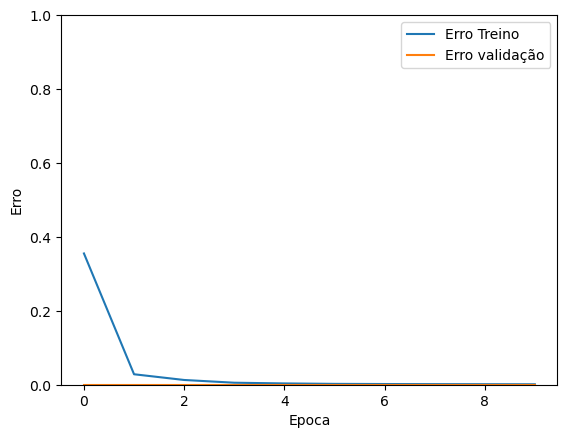

In [26]:
historico = np.array(historico)

plt.plot(historico[:,0:2])
plt.legend(['Erro Treino', 'Erro validação'])
plt.xlabel('Epoca')
plt.ylabel('Erro')
plt.ylim(0,1)
plt.show()

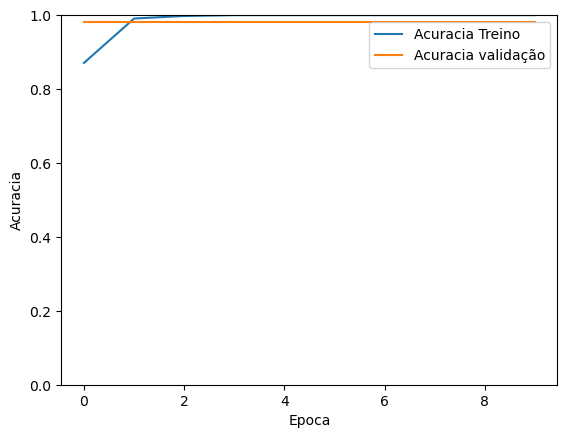

In [27]:
historico = np.array(historico)

plt.plot(historico[:,2:])
plt.legend(['Acuracia Treino', 'Acuracia validação'])
plt.xlabel('Epoca')
plt.ylabel('Acuracia')
plt.ylim(0,1)
plt.show()

## Função de predição

Vamos criar uma função para prever a classe de uma imagem com o melhor modelo treinado. É bem parecido com o que ´pe feito na validação

In [28]:
def predicao_lets_veggie(imagem_teste):
    #Parametros: imamgem_teste - imagente ja transformada com o PIL
    
    transformacao = transformacoes_de_imagens['teste']
    tensor_imagem_teste = transformacao(imagem_teste)
    
    if torch.cuda.is_available():
        tensor_imagem_teste = tensor_imagem_teste.view(1, 3, image_size, image_size).cuda()
    else:
         tensor_imagem_teste = tensor_imagem_teste.view(1, 3, image_size, image_size)
            
    dict_predicoes = dict()
   

    with torch.no_grad():
        modelo_treinado.eval()
        predicoes_log = modelo_treinado(tensor_imagem_teste)
        predicoes = torch.exp(predicoes_log)
        
        dict_predicoes = {indice_para_classe[classe]: float(predicoes[0][classe]) for classe in range(numero_de_classes)}
        
    
    return dict_predicoes
    

## Previsão em imagens de teste

'batata'

'cenoura'

'limao'

'batata'

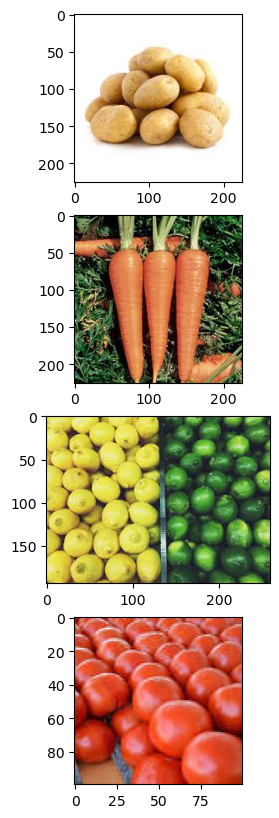

In [29]:
figura, plots = plt.subplots(nrows=numero_de_classes, ncols=1, figsize=(5,10))

for indice, classe in enumerate(pastas_com_nomes_de_vegetais):
    pasta = os.path.join(pasta_teste, classe)
    imagem = os.path.join(pasta, os.listdir(pasta)[1])
    imagem_teste = PIL.Image.open(imagem)
    
    plots[indice].imshow(imagem_teste)
    
    predicoes = predicao_lets_veggie(imagem_teste)
    
    display(max(predicoes, key = predicoes.get))

In [30]:
#função que perpassa todas as imagens na pasta de teste
#realiza a predição e calcula a acuracia

def acuracia_teste (pasta_teste):
    acertos = 0
    total_imagens = 0
    
    for classe in os.listdir(pasta_teste):
        pasta_completa = os.path.join(pasta_teste, classe)
        total_imagens += len(os.listdir(pasta_completa))
        
        for imagem in os.listdir(pasta_completa):
            imagem = os.path.join(pasta_completa, imagem)
            imagem_teste = PIL.Image.open(imagem)
            predicoes = predicao_lets_veggie(imagem_teste)
            predicao = max(predicoes, key=predicoes.get)
            
            if predicao==classe:
                acertos+=1
                
            
    return 100*acertos/total_imagens
        

In [31]:
acuracia_teste(pasta_teste)

96.49122807017544

## Deploy do Modelo

Vamos fazer uma aplicação simples utilizando o Gradio.

In [32]:
#!pip install gradio

In [33]:
#pip install typing_extensions==4.8.0

In [34]:
import gradio as gr

interface_gradio = gr.Interface(fn=predicao_lets_veggie, 
                               inputs=gr.Image(type="pil"),
                               outputs="label")

interface_gradio.launch(share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://69069489d555d46194.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
